<img src='https://www.met.no/om-oss/logo/_/image/73f29cde-219f-487b-809c-9cdd61032c78:2efc46ce776f5f5337c4b0156ae0cbaa3b6bf6fe/width-768/Met_RGB_Horisontal.jpg' width=200 align=right>
<img src='https://raw.githubusercontent.com/norkyst/norkyst-logo/refs/heads/main/png/horizontal_35_91_100.png' width=200 align=right>

# _Under construction_
# Current rose

This notebook will give instructions on how to produce a current rose using Norkyst v3 data. Data which are used here is found on The Norwegian Meteorological Institute's THREDDS server: https://thredds.met.no/thredds/catalog.html

For more information about Norkyst, see the notebook `about_norkyst_v3.ipynb`.

__Purpose__

A current rose, or wind rose, is a useful way to visualize in which direction currents are moving for a location. It is a circular histogram which display the magnitude, direction, and frequency of currents at a point location. This is a common product used in meteorology, so we will make use of the Python package `MetPy`to calculate the speed and direction of the currents, while we will use the package `windrose` for the plotting itself. 

 This is normally seen as a product over time, either daily or longer periods. 

In [13]:
import cmocean 
import metpy  
import numpy as np
import pandas as pd
import windrose
import xarray as xr
import xroms

In [14]:
path = 'https://thredds.met.no/thredds/dodsC/romshindcast/norkyst_v3/zdepth/2024/05/norkyst800-20240531.nc'

ds = xr.open_dataset(path)

In [15]:
ds

<xarray.Dataset>
Dimensions:           (X: 2747, Y: 1148, depth: 25, time: 24)
Coordinates:
  * X                 (X) float64 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y                 (Y) float64 0.0 800.0 1.6e+03 ... 9.168e+05 9.176e+05
  * depth             (depth) float64 0.0 1.0 2.0 3.0 ... 2e+03 2.25e+03 2.5e+03
  * time              (time) datetime64[ns] 2024-05-31 ... 2024-05-31T23:00:00
    lat               (Y, X) float64 ...
    lon               (Y, X) float64 ...
Data variables:
    projection_stere  int32 ...
    Uwind_eastward    (time, Y, X) float32 ...
    Vwind_northward   (time, Y, X) float32 ...
    h                 (Y, X) float32 ...
    ln_AKs            (time, depth, Y, X) float32 ...
    salinity          (time, depth, Y, X) float32 ...
    sea_mask          (Y, X) float32 ...
    temperature       (time, depth, Y, X) float32 ...
    u_eastward        (time, depth, Y, X) float32 ...
    v_northward       (time, depth, Y, X) float32 ...
    zeta              (time, Y, X) float32 ...
Attributes: (12/34)
    id:                              b259be19-2f4b-450b-8b19-30365e54f813
    naming_authority:                no.met
    operational_status:              scientific
    iso_topic_category:              oceans
    activity_type:                   Numerical Simulation
    keywords_vocabulary:             GCMDSK:GCMD Science Keywords:https://gcm...
    ...                              ...
    license:                         https://spdx.org/licenses/CC-BY-4.0 (CC-...
    title:                           Norkyst-800m - ROMS, Norkyst-800m ocean ...
    summary:                         Norkyst-800m (Norwegian Coast 800m horiz...
    title_no:                        Hindcast prognoser fra havmodellen Norky...
    summary_no:                      NorKyst-800m (Norske kystområder med 800...
    DODS_EXTRA.Unlimited_Dimension:  time

The variables of our dataset does not have latitude and longitude as dimensions, but X and Y. So to find data for a wanted location of latitude and longitude, we need to find the closest point within the domain and get the indices of `lat(Y,X)`and `lon(Y, X)`. There are many different approaches to solve this, but the least time consuming would be to use the Python package `xroms`which is made specifically to handle ROMS files. The function `xroms.argsel2d()` uses Great Circle Distance to calculate distance, and finds the closest lat/lon in your dataset.

In [16]:
xroms.argsel2d?

Signature: xroms.argsel2d(lons, lats, lon0, lat0)
Docstring:
Find the indices of coordinate pair closest to another point.

Parameters
----------
lons: DataArray, ndarray, list
    Longitudes of points to search through for closest point.
lats: DataArray, ndarray, list
    Latitudes of points to search through for closest point.
lon0: float, int
    Longitude of comparison point.
lat0: float, int
    Latitude of comparison point.

Returns
-------
Index or indices of location in coordinate pairs made up of lons, lats
that is closest to location lon0, lat0. Number of dimensions of
returned indices will correspond to the shape of input lons.

Notes
-----
This function uses Great Circle distance to calculate distances assuming
longitudes and latitudes as point coordinates. Uses cartopy function
`Geodesic`: https://scitools.org.uk/cartopy/docs/latest/cartopy/geodesic.html

If searching for the closest grid node to a lon/lat location, be sure to
use the correct horizontal grid (rho, u, v, or

In [17]:
# Target location
lat = 68.678
lon = 4.78

In [18]:
# Comparing the wanted longitude and latitude with the coordinates available in the dataset
y_idx, x_idx = xroms.argsel2d(ds.lon, ds.lat, lon, lat)  # storing the indices of the closest latitude and longitude


# Checking to see how close we got to the target
print(ds.lon[y_idx, x_idx].values)
print()
print(ds.lat[y_idx, x_idx].values)

4.776565411652501

68.68066132799903


Note how the output of `xroms.argsel2d()` is two indices, which are used to access both latitude and longitude.

Now we know how to access our location, let's use `metpy` to find the speed and direction of currents here. 

In [19]:
u = ds.u_eastward[:, 0, y_idx, x_idx]  # eastward velocity for all time steps, surface level and target location
v = ds.v_northward[:, 0, y_idx, x_idx]  # northward velocity for all time steps, surface level and target location

When finding the direction of the currents we can specify whether it is 'to' or 'from'. In meteorology it is most common to look at where the winds are coming from, but we want to know which direction the current is headed. Therefore, specify `convention=to`.

In [20]:
# Get the speed and direction of the surface currents
unit = metpy.units.units('m/s')
speed = np.squeeze(metpy.calc.wind_speed(u.values*unit, v.values*unit))
direction = np.squeeze(metpy.calc.wind_direction(u.values*unit, v.values*unit, convention='to'))

deg = np.array(np.round(direction, 1))
spd = np.array(np.round(speed, 2))

Now we have everything we need to make the rose diagram. For cosmetic reasons we can also make the timestamp prettier and include in the plot title. As the dataset we use in this example contains hgourly values for one day, we can take the first time step to be our date.

In [21]:
date = pd.Timestamp(ds.time[0].values).strftime('%Y-%m-%d')  # formatting time stamp

`windrose`is the only Python package we need to plot the current rose, as it has `matplotlib.pyplot` built in. 

Text(0.5, 1.0, 'Surface current speed and direction, 68.68 N, 4.78 E 2024-05-31')

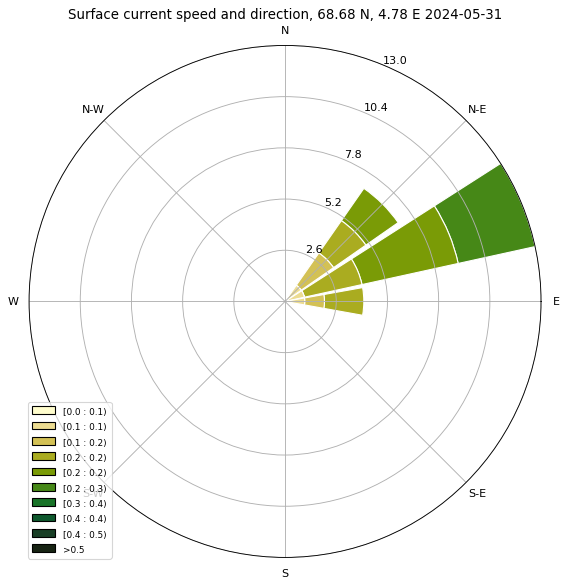

In [22]:
ax = windrose.WindroseAxes.from_ax()
ax.bar(deg, spd, opening = 0.9, edgecolor = 'white', bins = np.arange(0, 0.5, 0.05), cmap=cmocean.cm.speed)
ax.set_legend()
ax.set_title(f'Surface current speed and direction, {ds.lat[y_idx, x_idx].values:.2f} N, {ds.lon[y_idx, x_idx].values:.2f} E {date}')

You can customize the diagram by tweaking the parameters: opening, bins and of course the colormap used. 